<a href="https://colab.research.google.com/github/algo74/MLCourse/blob/master/HW3/HW3_Problem2_fulltraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning VGG19 

This is based on `pretrained_convnet_finetuning.ipynb` and Problem 2

In [0]:
import keras

Using TensorFlow backend.


## Mount Google Drive

In [0]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
file_prefix = '/gdrive/My Drive/HW3/'
# test saving files
with open(file_prefix + 'foo.txt', 'w') as f:
  f.write('Hello Google Drive!')
!cat "{file_prefix}foo.txt"

Mounted at /gdrive
Hello Google Drive!

## Download the data

Download the example data, a zip. of 2,000 JPG pictures of cats and dogs and extract it locally in ```/tmp```.



In [0]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2019-04-14 21:04:12--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.133.128, 2a00:1450:400c:c04::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.133.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  79.6MB/s    in 0.8s    

2019-04-14 21:04:13 (79.6 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Note that the data provided by Google does not have a test set.

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

## Build the model

### Load the saved model

In [0]:
file_name = file_prefix + 'Problem1_take6_step2.h5'
model = keras.models.load_model(file_name)
print('Loaded model from ' + file_name)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Loaded model from /gdrive/My Drive/HW3/Problem1_take6_step2.h5


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 22,122,049
Trainable params: 22,122,049
Non-trainable params: 0
_________________________________________________________________


In [0]:
conv_base = model.layers[0]
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

## Fine-tuning

Allow training the whole VGG19

In [0]:
conv_base.trainable = True

# set_trainable = False
# for layer in conv_base.layers:
#   if layer.name == 'block5_conv1':
#     set_trainable = True
#   if set_trainable:
#     layer.trainable = True
#   else:
#     layer.trainable = False

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import preprocess_input
from keras import optimizers
from keras import callbacks

# data augmentation

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    # rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=[0.8, 1.4],
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# compile model

model.compile(
    loss='binary_crossentropy',
    #
    # choose a smaller learning rate
    #
    optimizer=optimizers.RMSprop(lr=5e-6), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    callbacks = [callbacks.ReduceLROnPlateau(monitor='loss', patience=10, factor=0.3, verbose=1, min_lr=1e-7)],
    validation_data=validation_generator,
    validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 57s 572ms/step - loss: 0.4415 - acc: 0.9305 - val_loss: 0.2591 - val_acc: 0.9620
Epoch 2/100
100/100 [==============================] - 52s 517ms/step - loss: 0.3169 - acc: 0.9320 - val_loss: 0.1674 - val_acc: 0.9640
Epoch 3/100
100/100 [==============================] - 51s 512ms/step - loss: 0.2522 - acc: 0.9435 - val_loss: 0.1693 - val_acc: 0.9640
Epoch 4/100
100/100 [==============================] - 51s 512ms/step - loss: 0.1689 - acc: 0.9560 - val_loss: 0.1507 - val_acc: 0.9770
Epoch 5/100
100/100 [==============================] - 51s 513ms/step - loss: 0.1730 - acc: 0.9510 - val_loss: 0.1322 - val_acc: 0.9710
Epoch 6/100
100/100 [==============================] - 51s 513ms/step - loss: 0.1960 - acc: 0.9440 - val_loss: 0.1162 - val_acc: 0.9690
Epoch 7/100
100/100 [==============================] - 51s 513ms/step - loss: 0.1188 - acc: 0.9605 -

## Display learning curves during fine-tuning

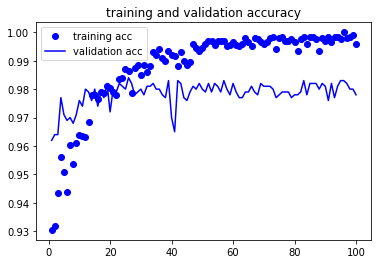

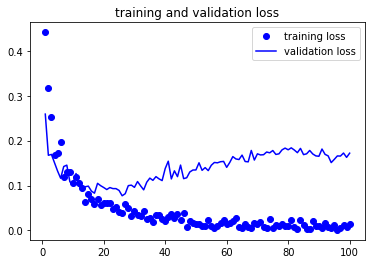

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

This looks like  significant overfitting.

## Print out validation loss and accuracy

In [0]:
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)

In [0]:
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

Validation loss: 0.17038292752477177
Validation accuracy: 0.9769999957084656


## Save the model

In [0]:
model_fname = file_prefix + 'Problem2_fulltake6.h5' 
model.save(model_fname)

## Conclusions

Unfreezing the whole network improved the validation accuracy by another percent, which is better than unfreezing only the last convolutional layer. 

Some overfitting was observed. Possibly more aggressive data augmentation and/or more dropouts could help reach even better results (but the training set is quite small).